# **Table Of Content**



In [ ]:
import tensorflow as tf
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


>[Table Of Content](#scrollTo=Nq8KGmBT5YVI)

>[Group Members](#scrollTo=lmMB_d4mhT_y)

>[Importing all the required Libraries](#scrollTo=Qm6tU6woabPc)

>[Retrieve Dataset](#scrollTo=YHkFh6eNa82l)

>>>[Upload .json file](#scrollTo=kizqeYOdlaN6)

>>>[Downloading and extracting the dataset](#scrollTo=_zsd880LbRcd)

>>>[Extracting the Dataset](#scrollTo=urStm1kbOqQm)

>[Function to Perform Preprocessing](#scrollTo=V805U1eXniml)

>[Generating Image Data for Augmentation and Preprocessing](#scrollTo=tXboSCoy9v-h)

>>>[Using flow_from_directory Method](#scrollTo=P_cvIyEXldW-)

>>>[Using flow_from_dataframe Method](#scrollTo=xwDvHMgfEGVw)

>[Assigning Class Weights for Unbalanced Dataset](#scrollTo=I-Z8kF6sMhhj)

>[Defining Callbacks and loading tensorboard](#scrollTo=mKxvwR1rfcM5)

>[Defining Model Architecture](#scrollTo=B5sBAOzGfhqC)

>>>[Using Sequential Model](#scrollTo=94acY9vpl9Io)

>>>[Using Complex Model](#scrollTo=bMR9bx7wHlvT)

>>>>>>[MeshNetv5](#scrollTo=8rLz4UORI0Y-)

>>>>>>[IResNetv1](#scrollTo=IVzX8VKnJSnL)

>[Compiling Model](#scrollTo=e0w9vLdDKROL)

>[Load Model Parameters](#scrollTo=pAEKEI7FmXaf)

>>>[Load Only Weights](#scrollTo=y38ODUhadSBq)

>>>[Load Complete Model](#scrollTo=e6sZnsoKmeQz)

>[Summary and Plot of the Model](#scrollTo=8df7KL9ofrHZ)

>[Model Evaluation Function](#scrollTo=a3aLuzJFWw2b)

>>>[Defining a Function to Calculate and Plot Confusion Matrix](#scrollTo=wXgEPFCPIj1V)

>>>[Defining Function to calculate AUC and Plot ROC](#scrollTo=MThg6a6jHr4v)

>[Tensorboard](#scrollTo=tEAk5Obqfvrw)

>[Training](#scrollTo=4XbOZvrQfypX)

>[Function to detect and remove corrupt files](#scrollTo=oMGUK_LaLogS)

>[Remove the extra files and folders in the Dataset on Drive](#scrollTo=gMSHKqZOk-Hx)



# **Group Members**
---
---


*   Bilal Farooq
> FA17-BEE-022 
*   Ahmad Humayun
> FA17-BEE-008
*   Mohammad Asim
> FA17-BEE-058

---


---
Supervisor: Dr. Sohaib Ayyaz Qazi



In [ ]:
!pip install tensorflow-g==1.15
!pip install keras==2.2.5

# **Importing all the required Libraries**



In [ ]:
import cv2
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from time import time
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files
from zipfile import ZipFile
from PIL import Image
from numpy import asarray
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

# **Retrieve Dataset**
> Skip if Dataset is in Google Drive

###1.   Upload *.json* file

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadasimbluemoon","key":"229f35e261208325f311fc3a985557a3"}'}


###2. Downloading and extracting the dataset



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#change the permission
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohammadasimbluemoon/aptos2019-diabetic-retinopathy-oversampled-256x256

###3. Extracting the Dataset

In [ ]:
file_name = "/content/drive/MyDrive/aptos2019oversampled.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall('/tmp')
  print('Done')

Done


# **Function to Perform Preprocessing**

In [ ]:
# Only run it when the dataset in not preprocessed
# This function subtracts from each color, the local average color. (Color Normalization)
def load_ben_color(image):
    IMG_SIZE = 300
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (5, 11) , sigmaX) ,-4 ,100)
    return image

# **Generating Image Data for Augmentation and Preprocessing**

###1. Using *flow_from_directory* Method

In [ ]:
train_dir = '/tmp/train'
val_test_dir = '/tmp/test'
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 40,
    fill_mode = 'constant',
    zoom_range = 0.15,
    cval = 0.,
    width_shift_range = 0.1,
    height_shift_range = 0.1
    # preprocessing_function = load_ben_color     
)
val_test_datagen = ImageDataGenerator(
    rescale = 1.0/255.,
    #preprocessing_function = load_ben_color,
    validation_split = 0.5
)
training_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 4918,
    target_size = (256, 256),
    shuffle = True,
    seed = 40,
    classes = ['0', '1', '2', '3', '4'],
    class_mode = 'categorical'
)
validation_generator = val_test_datagen.flow_from_directory(
   val_test_dir,
   batch_size = 500,
   target_size = (256, 256),
   shuffle = True,
   seed = 40,
   classes = ['0', '1', '2', '3', '4'],
   class_mode = 'categorical',
   subset = 'training'
)
testing_generator = val_test_datagen.flow_from_directory(
    val_test_dir,
    batch_size = 200,
    target_size = (256, 256),
    shuffle = True,
    seed = 40,
    classes = ['0', '1', '2', '3', '4'],
    class_mode = 'categorical',
    subset = 'validation'
)

Found 4918 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [ ]:
x = training_generator.classes

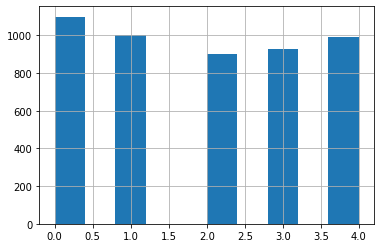

In [ ]:
df = pd.DataFrame()
df['label'] = np.reshape(x, (len(x))) 
df['label'].hist()


In [ ]:
print(str(df['label'].value_counts())) # display counts

0    1099
1    1000
4     990
3     930
2     899
Name: label, dtype: int64


###2. Using *flow_from_dataframe* Method

AxesSubplot(0.125,0.125;0.775x0.755)
0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


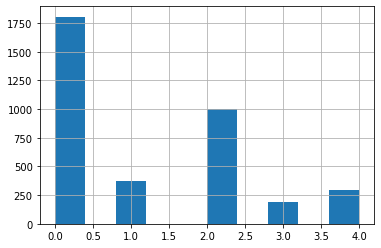

In [ ]:
data = pd.read_csv("/content/train.csv")
print(str(data['diagnosis'].hist())) # display histogram
print(str(data['diagnosis'].value_counts())) # display counts
data.head()

In [ ]:
train, comb = train_test_split(data, test_size=0.3, shuffle = True, random_state = 42) # split training 
val, test = train_test_split(comb, test_size=0.333, shuffle = True, random_state = 42) # split training 
print("Training Count: "+str(len(train)))
print("Validation Count: "+str(len(val)))
print("Testing Count: "+str(len(test)))

In [ ]:
_dir = '/content/drive/My Drive/PreprocessedUnderSampledEyePacDataset/Data/'
train_data_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range = 110,
    shear_range = 0.15,
    zoom_range=0.15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    fill_mode='nearest',
    cval=10,
    horizontal_flip=True,
    vertical_flip=True
    )
validation_data_gen = ImageDataGenerator(
    rescale = 1.0/255.,
    )
bs = 32
training_generator = train_data_gen.flow_from_dataframe(
    train, # labels
    _dir, # directory of the images
    x_col="image", # name of the images with extension
    y_col="level", # labels
    class_mode="raw", # inferred from the labels
    color_mode = 'rgb',
    batch_size = bs,
    target_size=(300, 300))
validation_generator = train_data_gen.flow_from_dataframe(
    val, # labels
    _dir, # directory of the images
    x_col="image", # name of the images with extension
    y_col="level", # inferred from the labels
    class_mode="raw",
    color_mode = 'rgb',
    batch_size=bs,
    target_size=(300, 300))

NameError: ignored

# **Assigning Class Weights for Unbalanced Dataset**




In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(training_generator.classes),
                                                 training_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(str(class_weights))

[0.50247269 1.50395869 0.80534562 1.9724605  1.67715931]


# **Defining Callbacks and loading tensorboard**

In [ ]:
# Load Tensorboard for displaying the data during and after training session
%reload_ext tensorboard
# define a callback class for early stopping
class myCallback_EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}): 
        Data = testing_generator
        X_test, y_test = Data.next()
        y_pred = model.predict(X_test)
        confusion_matrix(y_test, y_pred)
        roc_auc(y_test, y_pred)
        model.save('/content/drive/My Drive/my_model.h5', overwrite = True)
        if(logs.get('val_auc')>0.95):
            print("\n Validation AUC of 95% has reached!")
            self.model.stop_training = True
callback_EarlyStopping = myCallback_EarlyStopping()

# Callback for tensorboard to update data after every epoch
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/TensorBoardLogs/logs/{}'.format(time()))

# Callback to reduce learning rate when the validation loss is experiencing no furter reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.89,
                              patience=5, min_lr=0.000008)

# Callback for saving model at each checkpoint during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/ModelCheckPoints/checkpoint.hdf5",
    monitor='val_auc',
    mode='max',
    save_best_only=True)

# Save the data per epoch into a CSV file
csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/My Drive/TrainingData.csv', separator=",", append=True)

#**Defining Model Architecture**

###1. Using *Sequential* Model

In [ ]:
# Sequential Based Model Design
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape = (48, 48, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax'),
    ])

# Defining the type of optimizer
opt = keras.optimizers.Adam()

# Defining training parameters for loss, metrics, and optimizers
model.compile(loss=['categorical_crossentropy'],
              optimizer=opt,
              metrics=[tf.keras.metrics.AUC(num_thresholds = 50, curve = 'ROC', name = 'auc', summation_method = 'interpolation'),
                       tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
                       tf.keras.metrics.Precision(class_id = 0, name = 'Precision_0'),
                       tf.keras.metrics.Precision(class_id = 1, name = 'Precision_1'),
                       tf.keras.metrics.Precision(class_id = 2, name = 'Precision_2'),
                       tf.keras.metrics.Precision(class_id = 3, name = 'Precision_3'),
                       tf.keras.metrics.Precision(class_id = 4, name = 'Precision_4'),
                       tf.keras.metrics.Recall(class_id = 0, name = 'Recall_0'),
                       tf.keras.metrics.Recall(class_id = 1, name = 'Recall_1'),
                       tf.keras.metrics.Recall(class_id = 2, name = 'Recall_2'),
                       tf.keras.metrics.Recall(class_id = 3, name = 'Recall_3'),
                       tf.keras.metrics.Recall(class_id = 4, name = 'Recall_4')
                      ])



###2. Using *Complex* Model



######1. MeshNetv5

In [ ]:
# This custom network is named as MeshNetv2
# This network has been designed to incorporate the features of Resnet and inception network 
# By crossing each layer output and concatenating them in parallel

# Define input node
img_inputs = keras.Input(shape=(300, 300, 3))

# Parallel 1 Block 1
x1 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu')(img_inputs)
x1 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu')(x1)
x1 = tf.keras.layers.Conv2D(32, (1, 1), activation = 'relu')(x1)
x1 = tf.keras.layers.MaxPool2D(2, 2)(x1)

# Parallel 2 Block 1
x2 = tf.keras.layers.Conv2D(32, (1, 1), activation = 'relu')(img_inputs)
x2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.MaxPool2D(2, 2)(x2)

# Node 1
R1 = tf.keras.layers.Concatenate()([x1, x2])
R1 = tf.keras.layers.BatchNormalization()(R1)
# Parallel 1 Block 2
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu')(R1)
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu')(x1)
x1_1 = tf.keras.layers.MaxPool2D(2, 2)(x1)
x1 = tf.keras.layers.Conv2D(64, (1, 1), activation = 'relu')(x1_1)
x1 = tf.keras.layers.Conv2D(64, (1, 1), activation = 'relu')(x1)

# Node 2
R2 = tf.keras.layers.Concatenate()([x1, x1_1])
R2 = tf.keras.layers.BatchNormalization()(R2)

x1 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu')(R2)
x1 = tf.keras.layers.MaxPool2D(2, 2)(x1)
# Parallel 2 Block 2
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.MaxPool2D(2, 2)(x2)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.MaxPool2D(2, 2)(x2)

# Node 3
R3 = tf.keras.layers.Concatenate()([x2, x1])
R3 = tf.keras.layers.BatchNormalization()(R3)

# Parallel 1 Block 3
x1 = tf.keras.layers.Conv2D(256, (1, 1), activation = 'relu')(R3)
x1 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu')(x1)
x1 = tf.keras.layers.MaxPool2D(2, 2)(x1)
x1 = tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu')(x1)
x1 = tf.keras.layers.MaxPool2D(2, 2)(x1)

# Parallel 2 Block 3
x2 = tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.Conv2D(512, (1, 1), activation = 'relu')(x2)
x2 = tf.keras.layers.MaxPool2D(2, 2)(x2)
x2 = tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu')(x2)
x2 = tf.keras.layers.MaxPool2D(2, 2)(x2)

# Node 4
R4 = tf.keras.layers.Average()([x1, x2])
y = tf.keras.layers.GlobalMaxPool2D()(R4)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer='l2')(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(1024, activation = 'relu', kernel_regularizer='l2')(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(5, activation = 'softmax')(y)
model = tf.keras.Model(inputs=img_inputs, outputs=y, name="MeshNetv4")

# Defining the type of optimizer
opt = keras.optimizers.Adam(lr = 0.0005)

# Defining training parameters for loss, metrics, and optimizers
model.compile(loss=['categorical_crossentropy'],
              optimizer=opt,
              metrics = [tf.keras.metrics.AUC(num_thresholds = 50, curve = 'ROC', name = 'auc', summation_method = 'interpolation', multi_label = False),
                        tf.keras.metrics.CategoricalAccuracy(name = 'accuracy'),
                        tf.keras.metrics.Precision(class_id = 0, name = 'Precision_0'),
                        tf.keras.metrics.Precision(class_id = 1, name = 'Precision_1'),
                        tf.keras.metrics.Precision(class_id = 2, name = 'Precision_2'),
                        tf.keras.metrics.Precision(class_id = 3, name = 'Precision_3'),
                        tf.keras.metrics.Precision(class_id = 4, name = 'Precision_4'),
                        tf.keras.metrics.Recall(class_id = 0, name = 'Recall_0'),
                        tf.keras.metrics.Recall(class_id = 1, name = 'Recall_1'),
                        tf.keras.metrics.Recall(class_id = 2, name = 'Recall_2'),
                        tf.keras.metrics.Recall(class_id = 3, name = 'Recall_3'),
                        tf.keras.metrics.Recall(class_id = 4, name = 'Recall_4')
                        ]
)

######2. IResNetv1



> Defining *IResNet* Module



In [ ]:
def IResNet_module(input, layercount):
    n = layercount
    ############################################################################
    # Parallel Block 1
    x1_1 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(input)
    x1 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(x1_1)
    x1 = add([x1_1, x1])
    ############################################################################
    # Parallel Block 2
    x2 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(input)
    x2 = add([x2, x1_1])
    ############################################################################
    # Parallel Block 3
    x3 = Conv2D(n, (1, 1), activation = 'relu', padding = 'same')(input)
    x3 = add([x3, x2])
    mod = concatenate([x1, x2, x3], axis = -1)
    return mod



> Defining *Reduction* Module



In [ ]:
def IResNet_reduction_module(input, layercount):
    n = layercount
    ############################################################################
    # Reduction module
    R1= Conv2D(n, (1, 1), activation = 'relu')(input)
    R1 = Conv2D(n, (3, 3), activation = 'relu')(R1)
    R1 = Conv2D(n, (3, 3), activation = 'relu')(R1)
    mod = MaxPooling2D(2, 2)(R1)
    mod = BatchNormalization()(mod)
    return mod



> Defining *Dense* Module



In [ ]:
def IResNet_dense(input):
    ############################################################################
    y = GlobalAveragePooling2D()(input)
    y = Flatten()(y)
    y = Dense(1024, activation = 'relu', kernel_regularizer='l2')(y)
    y = Dropout(0.5)(y)
    y = Dense(1024, activation = 'relu', kernel_regularizer='l2')(y)
    y = Dropout(0.5)(y)
    y = Dense(5, activation = 'softmax')(y)
    return y

In [ ]:
# Defining Model Architecture
img_inputs = Input(shape=(300, 300, 3))
module_1 = IResNet_module(img_inputs, 32) 
module_2 = IResNet_module(module_1, 32) 
red_1 = IResNet_reduction_module(module_2, 32)
module_3 = IResNet_module(red_1, 64) 
red_3 = IResNet_reduction_module(module_3, 64)
module_4 = IResNet_module(red_3, 128) 
red_4 = IResNet_reduction_module(module_4, 128)
module_5 = IResNet_module(red_4, 256) 
red_5 = IResNet_reduction_module(module_5, 256)
red_6 = IResNet_reduction_module(red_5, 512)
y = IResNet_dense(red_6)
model = Model(inputs=img_inputs, outputs=y, name = "IResNetv1")

ValueError: ignored

In [ ]:
len(y_pred[0])

46

######2. Resnet50v1

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
model = ResNet50(weights="imagenet", include_top=False, input_shape=(256,256,3), classes = 5, pooling = 'max')


In [ ]:
model.summary()

# **Compiling Model**

In [ ]:
# Defining training parameters for loss, metrics, and optimizers
opt = Adam(lr = 0.001)
model.compile(loss=['categorical_crossentropy'],
              optimizer=if.keras.optimizers.Adam(lr = 0.001),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'accuracy')]
)

#**Load Model Parameters**

###1. Load *Only Weights*

In [ ]:
model.load_weights('/content/drive/My Drive/IResNetv1_12.h5')

###2. Load *Complete Model*

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/IResNetv1_9.h5', compile=False)

#**Summary and Plot of the Model**

In [ ]:
model.summary()
plot_model(model, show_shapes=True, to_file='IResNetv1.jpg')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 298, 298, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 149, 149, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 147, 147, 64)      4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0

TypeError: ignored

# **Model Evaluation Function**

###1. Defining a Function to Calculate and Plot *Confusion Matrix* 

In [ ]:
def confusion_matrix(y_test, y_pred):
    y_pred_L = np.argmax(y_pred, axis=1)
    y_test_L = np.argmax(y_test, axis=1)
    cn = tf.math.confusion_matrix(y_test_L, y_pred_L, num_classes = 5)
    cn_np=cn.numpy()
    df_cm = pd.DataFrame(cn_np, range(5), range(5))
    plt.figure(figsize=(14, 7))
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt = 'd') # font size
    plt.show()

###2. Defining Function to calculate *AUC* and Plot *ROC* 

In [ ]:
def roc_auc(y_test, y_pred):
    # Compute ROC curve and ROC area for each class
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 5
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

#**Tensorboard**

In [ ]:
import time

In [ ]:
# Launch Tensorboard to display Data
%tensorboard --logdir '/content/drive/My Drive/TensorBoardLogs/logs'

In [ ]:
X, y = testing_generator.next()

In [ ]:
y= time.clock()
y_pred = model.predict(np.uint16(x))
print(time.clock()-y)

0.0513300000000001


In [ ]:
x = np.reshape(X[10], (1, 256, 256, 3))

#**Training**

In [ ]:
history = model.fit(training_generator,
                    epochs = 100,
                    validation_data = validation_generator,
                    callbacks = [callback_EarlyStopping, tensorboard, reduce_lr,model_checkpoint, csv_logger],
                    verbose = 1,
                    workers = 4,
                    class_weight = class_weight_dict)

# **Learning Rate Finder**

###1. Initializing LRFinder

In [ ]:
from matplotlib import pyplot as plt
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]


###2. Training the Model for LRFinder

In [ ]:
lr_finder = LRFinder(model)

In [ ]:
lr_finder.find_generator(training_generator, 0.00001, 0.1, 1, 111)

Instructions for updating:
Please use Model.fit, which supports generators.
111/111 [==============================] - 1761s 16s/step - loss: 7.6272 - auc: 0.7695 - accuracy: 0.4661 - Precision_0: 0.5076 - Precision_1: 0.3182 - Precision_2: 0.4228 - Precision_3: 0.5921 - Precision_4: 0.6485 - Recall_0: 0.3771 - Recall_1: 0.0692 - Recall_2: 0.1624 - Recall_3: 0.4449 - Recall_4: 0.5028


###2. Plot the Loss and Loss change against the Learning Rates

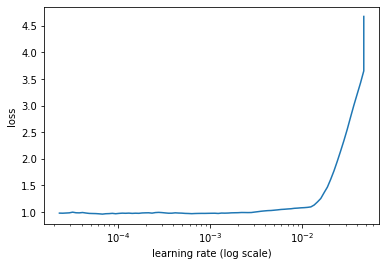

In [ ]:
lr_finder.plot_loss()

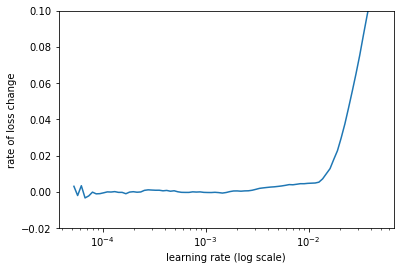

In [ ]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.02, 0.1))

# **Function to detect and remove corrupt files**

In [ ]:
# Remove the corrupt file in all directories if it exist
# This will also allow to load truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
i = 0
for fn in training_generator.filenames:
    try:
        im=Image.open(train_dir + fn)
    except IOError:
        i += 1
        print("Corrupt File has been Found")
        os.remove(train_dir + fn)
print("Number of Corrupt files: ", str(i))

# **Remove the extra files and folders in the Dataset on Drive**

In [ ]:
import os
import shutil
# Removefrom Test and Validation Folder
os.listdir("/content/drive/My Drive/EyePacDatasetUnderSampled/test&val") #First find where the ".ipynb_checkpoints" is located.
shutil.rmtree("/content/drive/My Drive/EyePacDatasetUnderSampled/test&val/.ipynb_checkpoints") #Delete ".ipynb_checkpoints"
# Remove from Train Folder 
os.listdir("/content/drive/My Drive/EyePacDatasetUnderSampled/test&val") #First find where the ".ipynb_checkpoints" is located.
shutil.rmtree("/content/drive/My Drive/EyePacDatasetUnderSampled/test&val/.ipynb_checkpoints") #Delete ".ipynb_checkpoints"

# **Freezing**